# Investigating User Behaviour

This project involves investigating user behavior within a food product startup's app. Firstly, the sales funnel will be analyzed to determine how users progress towards making a purchase, identifying where users may drop off. Secondly, an A/A/B test will be conducted to assess the impact of changing the app's fonts on user behavior. By comparing two control groups with the old fonts against one test group with new fonts, the study aims to determine which set of fonts yields better results. This approach allows for a thorough analysis of user engagement and provides insights into potential design changes without disrupting user experience.

# Table of Contents

- [Description of the Data](#description) <br>
- [Data Inspection](#inspect)<br>
- [Data Preprocessing](#processing)<br>
- [Event Funnel Study](#funnel)<br>
- [Experiment Results Study](#results)<br>

## Description of the Data <br>
<div id='description' ></div>

logs:
- EventName — event name
- DeviceIDHash — unique user identifier
- EventTimestamp — event time
- ExpId — experiment number: 246 and 247 are the control groups, 248 is the test group

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt

In [2]:
#importing data
try:
    logs = pd.read_csv(m)
except:
    logs = pd.read_csv('/datasets/logs_exp_us.csv',sep='\t')

## Data Inspection <br>
<div id='inspect'></div>

In [3]:
#inspecting logs table
logs.info()
print(f'Missing values in logs table {logs.isna().sum()}')
print(f'Duplicated values in logs table {logs.duplicated().sum()}')
logs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
Missing values in logs table EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64
Duplicated values in logs table 413


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
#Converting EventTimestamp column to datetime type
logs['EventTimestamp'] = pd.to_datetime(logs['EventTimestamp'], unit='s')
logs.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [5]:
#changing column names to lower case
logs.rename(columns={'EventName':'eventname','DeviceIDHash':'deviceid','EventTimestamp':'eventtime','ExpId':'expid'},inplace=True)
logs

,eventname,deviceid,eventtime,expid
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


In [6]:
#creating date and time columns
logs['date'] = pd.to_datetime(logs['eventtime']).dt.date
logs['date'] = pd.to_datetime(logs['date'],format='%Y-%m-%d')
logs['time'] = pd.to_datetime(logs['eventtime']).dt.time
logs.head(5)

,eventname,deviceid,eventtime,expid,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


In [7]:
#inspecting duplicated values 
logs[logs.duplicated()==True]

,eventname,deviceid,eventtime,expid,date,time
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30,08:19:44
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31,21:51:39
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01,02:59:37
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247,2019-08-01,03:47:46
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248,2019-08-01,04:44:01
...,...,...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,2019-08-07 19:26:44,247,2019-08-07,19:26:44
242332,PaymentScreenSuccessful,4718002964983105693,2019-08-07 19:26:45,247,2019-08-07,19:26:45
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07,19:27:29
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07,19:27:29


Comment: The duplicated data can be deleted from the dataset as it makes up less than 0.01% of the dataset. The removal on these records won't have a significant difference on the dataset.

In [8]:
#deleting duplicated data 
logs = logs.drop_duplicates()
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   eventname  243713 non-null  object        
 1   deviceid   243713 non-null  int64         
 2   eventtime  243713 non-null  datetime64[ns]
 3   expid      243713 non-null  int64         
 4   date       243713 non-null  datetime64[ns]
 5   time       243713 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 13.0+ MB


## Data Preprocessing <br>
<div id='processing'></div>

### How many events are in the logs?

In [9]:
print(f"There are a total of {logs['eventname'].count()} events in the logs table and {len(logs['eventname'].unique())} different unique events in the logs table.")

There are a total of 243713 events in the logs table and 5 different unique events in the logs table.


### How many users are in the logs?

In [10]:
print(f"There are {len(logs['deviceid'].unique())} users in the logs table.")

There are 7551 users in the logs table.


### What's the average number of events per user?

In [11]:
avg_events = logs['eventname'].count()/len(logs['deviceid'].unique())
print(f"The average number of events per user is {avg_events}.")

The average number of events per user is 32.27559263673685.


### What period of time does the data cover?

In [12]:
#finding the maximum and minimum date
mindate = logs['date'].min()
maxdate = logs['date'].max()
print(f"Minimum date {mindate} and maximum date {maxdate}.")

Minimum date 2019-07-25 00:00:00 and maximum date 2019-08-07 00:00:00.


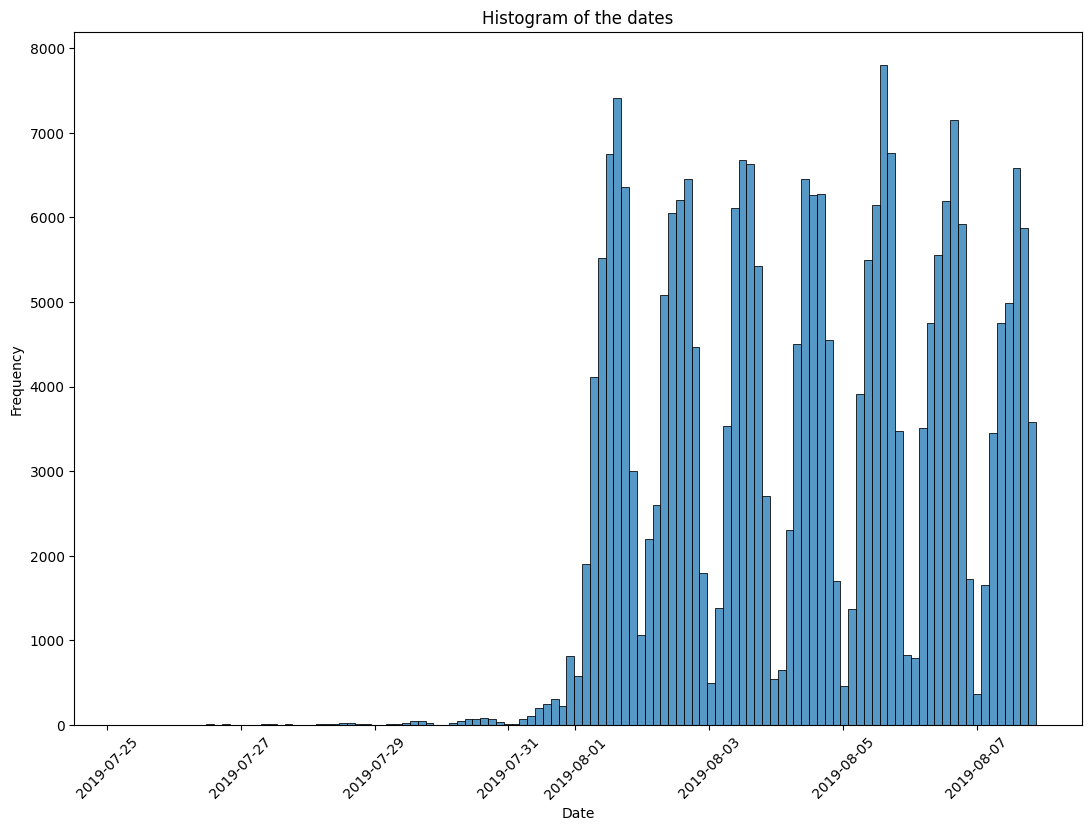

In [13]:
#plotting histogram by the date and time
plt.figure(figsize=(13,9))
sns.histplot(logs['eventtime'])
#plt.hist(logs['eventtime'])
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Histogram of the dates')
plt.show()

In [14]:
logsout = logs[logs['eventtime'] < '2019-08-01 00:00:00']
out = len(logsout)
out

2826

In [15]:
logsv2 = logs[logs['eventtime'] >= '2019-08-01 00:00:00']
remain = len(logsv2)
remain

240887

In [16]:
outratio = (out/len(logs))*100
print(f"The data before 2019-08-01 makes up {outratio}% of the total logs table which is 1% so that implies these records can be removed as there won't be a signifacant difference to the data.")

The data before 2019-08-01 makes up 1.159560630741897% of the total logs table which is 1% so that implies these records can be removed as there won't be a signifacant difference to the data.


Comment: Based on observing the graph above, the data starts to be complete from the 2019-08-01 until 2019-08-07. As the pattern observed above is a normal distribution for each day. There are no observed patterns prior the date 2019-08-01 and the amount of data is observed to be significantly little.

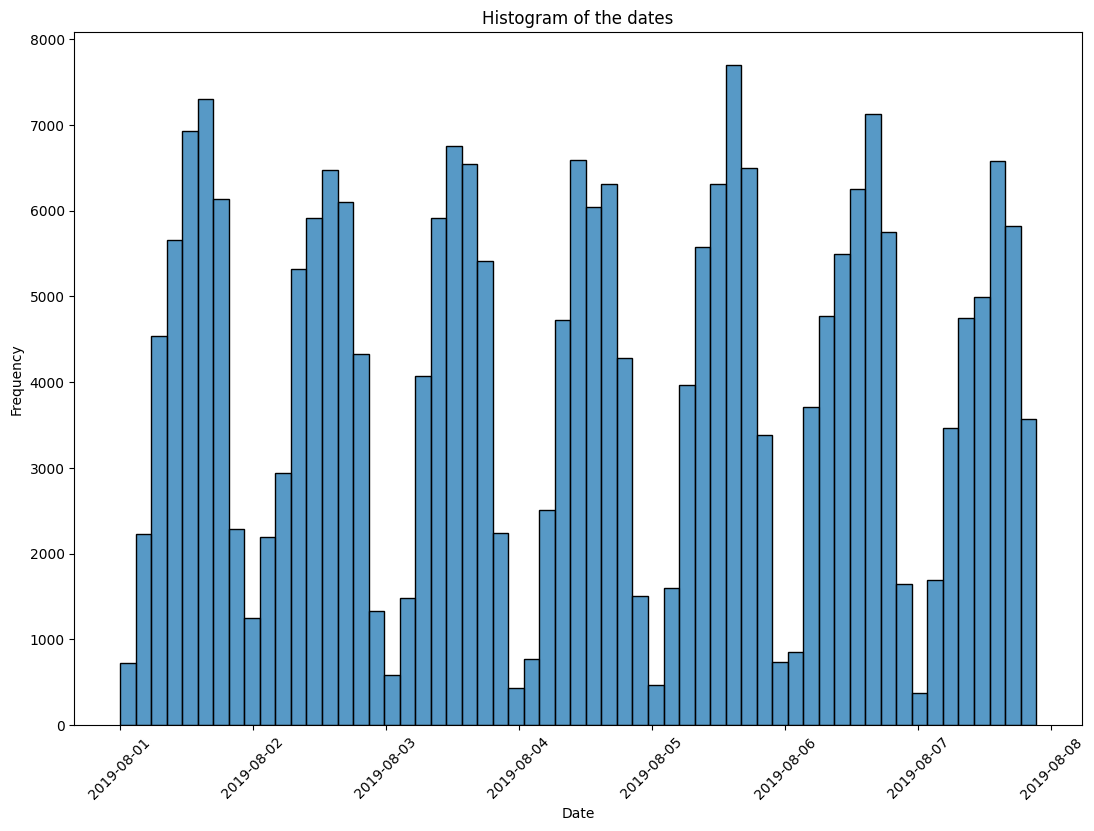

In [17]:
#plotting the actual period covered
plt.figure(figsize=(13,9))
sns.histplot(logsv2['eventtime'])
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Histogram of the dates')
plt.show()

Comment: The actual period covered is 2019-08-01 to 2019-08-07.

### Were many events and users lost when excluding the older data?

In [18]:
#calculating ratio of remaining users to total users
user_ratio = (len(logsv2['deviceid'].unique())/len(logs['deviceid'].unique()))*100
print(f"{user_ratio}% of users have remained. {100-user_ratio}% of users were lost.")

99.77486425638989% of users have remained. 0.22513574361011024% of users were lost.


In [19]:
#calculating ratio of remaining events to total events
event_ratio = (len(logsv2['eventname'])/len(logs['eventname']))*100
print(f"{event_ratio}% of events have remained. {100-event_ratio}% of events were lost.")

98.8404393692581% of events have remained. 1.1595606307418933% of events were lost.


### Are all users from all three experimental group present?

In [20]:
#grouping the experimental groups and creating a total row to count all the records
grouped = logsv2.groupby('expid').agg({'eventname':'count'})
total_row = pd.DataFrame({'eventname':[grouped['eventname'].sum()]}, index=['Total'])
complete = pd.concat([grouped,total_row])
complete

,eventname
246,79302
247,77022
248,84563
Total,240887


## Event Funnel Study <br> 
<div id='funnel'></div>

### Determining events in the logs and their frequency.

In [21]:
events_count = logsv2.groupby('eventname').agg({'eventname':'count'})
events_count.rename(columns = {'eventname':'event','eventname':'frequency'},inplace=True)
events_count = events_count.sort_values(by='frequency',ascending=False).reset_index()
events_count

,eventname,frequency
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


### Finding the number of users who performed each of these actions.

In [22]:
user_events = logsv2.groupby('eventname').agg({'deviceid':'nunique'})
user_events.rename(columns={'deviceid':'unique_users'},inplace=True)
user_events.sort_values(by='unique_users',ascending=False).reset_index()

,eventname,unique_users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


### Calculating the proportion of users who performed the action at least once

In [23]:
proportion = pd.merge(events_count,user_events,on='eventname')
proportion['proportion'] = proportion['unique_users']/proportion['frequency']
proportion.sort_values(by='proportion',ascending=False)

,eventname,frequency,unique_users,proportion
4,Tutorial,1005,840,0.835821
3,PaymentScreenSuccessful,33918,3539,0.104340
1,OffersScreenAppear,46333,4593,0.099130
2,CartScreenAppear,42303,3734,0.088268
0,MainScreenAppear,117328,7419,0.063233


Comment:
The order of the event actions is most likely as follows:
1. Tutorial (840 users watch the tutorial, the rest of the users skip the tutorial)
2. Main Screen Appear
3. Offers Screen Appear
4. Cart Screen Appear
5. Payment Screeb Successful

### Finding the share of users that proceed from each stage to the next

In [24]:
user_events['total conversion (%)'] = ((user_events['unique_users']/7419)*100).round()
user_events.sort_values(by='unique_users',ascending=False)

,unique_users,total conversion (%)
eventname,,
MainScreenAppear,7419,100.0
OffersScreenAppear,4593,62.0
CartScreenAppear,3734,50.0
PaymentScreenSuccessful,3539,48.0
Tutorial,840,11.0


Comment: Most users are lost when moving from the main screan to the offer screen. 

### What share of users make the entire journey from their first event to payment?

In [25]:
#filtering users with all events
all_event_users = logsv2.groupby('deviceid').agg({'eventname':'nunique'})
all_event_users.rename(columns = {'eventname':'number_of_events'},inplace=True)
all_event_users.reset_index()
all_event_users = all_event_users[all_event_users['number_of_events']==5]

#calculating share of users that make the entire journey
share = (len(all_event_users)/len(logsv2['deviceid'].unique()))*100
print(f"The share of users that make the journey through the entire journey is {share}% of the users.")

The share of users that make the journey through the entire journey is 6.185293336872843% of the users.


## Experiment Results Study <br>
<div id='results'></div>

### How many users are there in each group?

In [26]:
exp_group = logsv2.groupby('expid').agg({'deviceid':'nunique'})
total_row = pd.DataFrame({'deviceid':[exp_group['deviceid'].sum()]}, index=['Total'])
complete = pd.concat([exp_group,total_row])
complete

,deviceid
246,2484
247,2513
248,2537
Total,7534


### Checking if there is a statistically significant difference between samples 246 and 247

In [27]:
#grouping data by group 246 and 247
filtered_groups = logsv2[(logsv2['expid']==246) | (logsv2['expid']==247)].groupby(['expid','eventname']).size().unstack(fill_value=0)
filtered_groups

eventname,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
expid,,,,,
246,14690,37676,14767,11852,317
247,12434,39090,15179,9981,338


In [28]:
#performing ch-square test
chi2, p, dof, expected = chi2_contingency(filtered_groups)

#displaying results 
print("Chi-square statistic:", chi2)
print("P-value:", p)


Chi-square statistic: 347.1835264073801
P-value: 7.113427142599721e-74


Comment: The p-value is below 0.05 therefore there is no statistical difference between groups 246 and 247.

### Checking whether the difference between events in the controlled groups has a statistically significant.

In [29]:
#recalling the popular events
events_count

,eventname,frequency
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [30]:
#getting users performing the most popular events
users_per_event = logsv2.groupby(['expid','eventname']).agg({'deviceid':'nunique'}).reset_index().sort_values(by='deviceid',ascending=False)
users_per_event

,expid,eventname,deviceid
11,248,MainScreenAppear,2493
6,247,MainScreenAppear,2476
1,246,MainScreenAppear,2450
2,246,OffersScreenAppear,1542
12,248,OffersScreenAppear,1531
7,247,OffersScreenAppear,1520
0,246,CartScreenAppear,1266
5,247,CartScreenAppear,1238
10,248,CartScreenAppear,1230
3,246,PaymentScreenSuccessful,1200


In [31]:
#calculating share of users performing the event
total_users_per_group = logsv2.groupby('expid').agg({'deviceid':'nunique'})
users_group = pd.merge(users_per_event,total_users_per_group,on='expid')
users_group['not_performed'] = users_group['deviceid_y']-users_group['deviceid_x']
users_group['share'] = users_group['deviceid_x']/users_group['deviceid_y']
users_group.rename(columns={'deviceid_x':'performed','deviceid_y':'total_users'},inplace=True)
users_group

,expid,eventname,performed,total_users,not_performed,share
0,248,MainScreenAppear,2493,2537,44,0.982657
1,248,OffersScreenAppear,1531,2537,1006,0.603469
2,248,CartScreenAppear,1230,2537,1307,0.484825
3,248,PaymentScreenSuccessful,1181,2537,1356,0.465510
4,248,Tutorial,279,2537,2258,0.109972
5,247,MainScreenAppear,2476,2513,37,0.985277
6,247,OffersScreenAppear,1520,2513,993,0.604855
7,247,CartScreenAppear,1238,2513,1275,0.492638
8,247,PaymentScreenSuccessful,1158,2513,1355,0.460804
9,247,Tutorial,283,2513,2230,0.112614


In [32]:
#control group table
users_control_groups = users_group[(users_group['expid']==246) | (users_group['expid']==247)]
users_control_groups

,expid,eventname,performed,total_users,not_performed,share
5,247,MainScreenAppear,2476,2513,37,0.985277
6,247,OffersScreenAppear,1520,2513,993,0.604855
7,247,CartScreenAppear,1238,2513,1275,0.492638
8,247,PaymentScreenSuccessful,1158,2513,1355,0.460804
9,247,Tutorial,283,2513,2230,0.112614
10,246,MainScreenAppear,2450,2484,34,0.986312
11,246,OffersScreenAppear,1542,2484,942,0.620773
12,246,CartScreenAppear,1266,2484,1218,0.509662
13,246,PaymentScreenSuccessful,1200,2484,1284,0.483092
14,246,Tutorial,278,2484,2206,0.111916


In [33]:
#creating chi-test function
def chi_test_calculator(events,data):
    for event in events:
        table = data[data['eventname'] == event]
        cont_table = table.pivot(index='expid', columns='eventname',values=['performed','not_performed','share'])
        chi2, p, dof, ex = chi2_contingency(cont_table)
        print(f"For the event {event} the chi2={chi2} and the p-value={p}.")

In [34]:
#calculating chi test
events = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful','Tutorial']
chi_test_calculator(events,users_control_groups)

For the event MainScreenAppear the chi2=0.09577276467192558 and the p-value=0.9532420860641299.
For the event OffersScreenAppear the chi2=1.3344292392951609 and the p-value=0.5131358676550688.
For the event CartScreenAppear the chi2=1.4486162532477271 and the p-value=0.48465977617713585.
For the event PaymentScreenSuccessful the chi2=2.490884223218027 and the p-value=0.28781363424927914.
For the event Tutorial the chi2=0.0061108434896979084 and the p-value=0.9969492413057661.


Comment:

Null hypothesis: There is a significant difference between the event in different groups.

Alternative hypothesis: There is no significant difference between the event in different groups. 

Based on the chi test performed on all the events above the null hypothesis is rejected for all events as the p-values for all the events is larger than 0.05.

### Checking whether there is a statistically significant difference between the controlled groups and altered font group per event.

In [35]:
#retriving the control group 246 and the altered group 248
users_control246_altered_group = users_group[(users_group['expid']==246) | (users_group['expid']==248)]
users_control246_altered_group

,expid,eventname,performed,total_users,not_performed,share
0,248,MainScreenAppear,2493,2537,44,0.982657
1,248,OffersScreenAppear,1531,2537,1006,0.603469
2,248,CartScreenAppear,1230,2537,1307,0.484825
3,248,PaymentScreenSuccessful,1181,2537,1356,0.465510
4,248,Tutorial,279,2537,2258,0.109972
10,246,MainScreenAppear,2450,2484,34,0.986312
11,246,OffersScreenAppear,1542,2484,942,0.620773
12,246,CartScreenAppear,1266,2484,1218,0.509662
13,246,PaymentScreenSuccessful,1200,2484,1284,0.483092
14,246,Tutorial,278,2484,2206,0.111916


In [36]:
#retriving the control group 247 and the altered group 248
users_control247_altered_group = users_group[(users_group['expid']==247) | (users_group['expid']==248)]
users_control247_altered_group

,expid,eventname,performed,total_users,not_performed,share
0,248,MainScreenAppear,2493,2537,44,0.982657
1,248,OffersScreenAppear,1531,2537,1006,0.603469
2,248,CartScreenAppear,1230,2537,1307,0.484825
3,248,PaymentScreenSuccessful,1181,2537,1356,0.465510
4,248,Tutorial,279,2537,2258,0.109972
5,247,MainScreenAppear,2476,2513,37,0.985277
6,247,OffersScreenAppear,1520,2513,993,0.604855
7,247,CartScreenAppear,1238,2513,1275,0.492638
8,247,PaymentScreenSuccessful,1158,2513,1355,0.460804
9,247,Tutorial,283,2513,2230,0.112614


In [37]:
#calculating chi test
chi_test_calculator(events,users_control246_altered_group)

For the event MainScreenAppear the chi2=1.0970906664848872 and the p-value=0.5777896908153972.
For the event OffersScreenAppear the chi2=1.5835166696735212 and the p-value=0.4530474853426727.
For the event CartScreenAppear the chi2=3.0984101497060945 and the p-value=0.21241676215668354.
For the event PaymentScreenSuccessful the chi2=1.5567788624108192 and the p-value=0.4591449005785685.
For the event Tutorial the chi2=0.04816794273669292 and the p-value=0.9762037331528559.


In [38]:
#calculating chi test
chi_test_calculator(events,users_control247_altered_group)

For the event MainScreenAppear the chi2=0.5491246605870387 and the p-value=0.7599046376936383.
For the event OffersScreenAppear the chi2=0.010184269136687421 and the p-value=0.994920808370506.
For the event CartScreenAppear the chi2=0.30863005187371634 and the p-value=0.8570020006238419.
For the event PaymentScreenSuccessful the chi2=0.11247712987299473 and the p-value=0.9453135903111899.
For the event Tutorial the chi2=0.08916191108075759 and the p-value=0.9563981712287462.


Comment:

Null hypothesis: There is a significant difference between the event in different groups.

Alternative hypothesis: There is no significant difference between the event in different groups.

Based on the chi test performed on all the events agaisnt the altered group and the controlled group independently we can conclude that the null hypothesis is rejected for all events as the p-values for all the events is larger than 0.05. Implying the altered font has no significant impact on user behavior.

### Readjusting the signifance level

Current sigicance level.

In [39]:
print('α=0.05')

α=0.05


Number of Hypothesis Tests performed.

In [40]:
print(15)

15


Adjusting the significance level useing Bonferroni correction.

In [41]:
corrected_alpha = 0.05/15
print(f"Correct Alpha α={round(corrected_alpha,3)}.")

Correct Alpha α=0.003.


In [42]:
#creating chi-test function with corrected alpha
alpha = 0.05
def chi_test_calculator(events,data):
    for event in events:
        table = data[data['eventname'] == event]
        cont_table = table.pivot(index='expid', columns='eventname',values=['performed','not_performed','share'])
        chi2, p, dof, ex = chi2_contingency(cont_table)
        return chi2, p < alpha
        

In [43]:
#calculating chi2 and p value for controlled groups
chi_test_calculator(events,users_control_groups)

(0.09577276467192558, False)

In [44]:
#calculating chi2 and p value for controlled group 246 and altered group
chi_test_calculator(events,users_control246_altered_group)

(1.0970906664848872, False)

In [45]:
#calculating chi2 and p value for controlled group 247 and altered group
chi_test_calculator(events,users_control247_altered_group)

(0.5491246605870387, False)

#### Conclusion

There is no p-value that is smaller than 0.05 so we can conclude that there will be no value smaller than the adjusted alpha value of 0.003. We can conclude that our results will stay the same after adjusting the alpha value. For the two control groups, the control group 246 and the altered group, lastly, the control group 247 and the altered group have no statisitcally sigficant differences. Implying that the control groups are both stable and that changing the font does not have any significant impact on user behaviour.